In [3]:
import cv2
import face_detection
import numpy as np
from matplotlib import pyplot as plt

# CODE: https://github.com/hukkelas/DSFD-Pytorch-Inference

In [13]:
# to load the weights
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Process the face detection on a video
1. Load the numpy array generated from a video
1. Process the face detectio
1. Visual check of the performances

In [4]:
np.__version__

'1.19.5'

## Load the numpy array : 3D + 3D numpy with colors or 3D if gray

In [5]:
USE_COLOR = True 
SHOW_DET_FACES = True
fps_np = 1.

In [6]:
# Load the numpy array
path_arrays = "../data/arrays/"
array_name = 'BA_GNS_' + str(int(fps_np)) + 'fps'
#array_name = 'EJ_GNS_' + str(int(fps_np)) + 'fps'
if USE_COLOR:
    array_name += '_RGB'
else:
    array_name += '_Gray'
file_out = path_arrays + array_name + '.npy'

video_np = np.load(file=file_out)

video_np = video_np.astype(np.uint8)

In [7]:
# check the size of the video 
if USE_COLOR:
    nb_frame, height, width, color = video_np.shape
else:
    nb_frame, height, width = video_np.shape
    color = 1
    
print('Number of frame : ' + str(nb_frame))
print('Frame size WxH : ' + str(width) + 'x' + str(height))
print('Colors : ' + str(color))

Number of frame : 59
Frame size WxH : 320x180
Colors : 3


## Process the video

In [8]:
# Hyperparamters 

# contour margin for the face cropping
margin = 0

# mininum size of the face to be 
#min_face_size = 20

In [9]:
print('Available detectors: ' + ', '.join(face_detection.available_detectors))

Available detectors: DSFDDetector, RetinaNetResNet50, RetinaNetMobileNetV1


In [10]:
# Set the parameters for the face detector
# detector_net (string): Network detector type - Default 'DSFDDetector'
detectornet = "RetinaNetResNet50"
# confidence_threshold (float): Threshold to filter out bounding boxes - Default: 0.5
# nms_iou_threshold (float): Intersection over union threshold for non-maxima threshold - Default: 0.3
# device ([type], optional): Defaults to cuda if cuda capable device is available.
# max_resolution (int, optional): Max image resolution to do inference to.
# fp16_inference: To use torch autocast for fp16 inference or not - Default: False
# clip_boxes: To clip boxes within [0,1] to ensure no boxes are outside the image - Default: False

In [15]:
detector = face_detection.build_detector(detectornet)
#detector = face_detection.build_detector(
#  "DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)

# outputs
crop_faces = []
no_face = []
video_fd = np.copy(video_np)

Downloading: "https://folk.ntnu.no/haakohu/RetinaFace_ResNet50.pth" to /Users/aro/.cache/torch/hub/checkpoints/RetinaFace_ResNet50.pth
100.0%


In [16]:
# Detection with landmarks
# Takes N images and performs and returns a set of bounding boxes as detections
# Element 1 is an array with shape [N, 5] with (xmin, ymin, xmax, ymax, score) bounding boxes
# Element 2 is an array with shape [N, 5, 2] with 5 landmarks with (x, y)
video_np_detection_boxes, video_np_detection_landmarks = detector.batched_detect_with_landmarks(video_np)

#print("Number of processed frames: %d" % len(video_np_detection_boxes))
#print(video_np_detection_boxes)

for idx, (frame_idx, frame_idx_detection_boxes, frame_idx_detection_landmarks) in enumerate(zip(video_np, video_np_detection_boxes, video_np_detection_landmarks)):
    video_fd[idx, :] = frame_idx
    
    if len(frame_idx_detection_boxes) == 0:
        no_face.append(frame_idx)
    else:
        for frame_idx_detection_box, frame_idx_detection_landmark in zip(frame_idx_detection_boxes, frame_idx_detection_landmarks):
            x0, y0, x1, y1 = [int(_) for _ in frame_idx_detection_box[:4]]
            
            x = int(max(x0 - margin/2, 0))
            y = int(max(y0 - margin/2, 0))
            h = y1 - y0 + margin
            w = x1 - x0 + margin
            
            # save the crop images
            crop_face = frame_idx[y:y+h, x:x+w]
            crop_faces.append(crop_face)
            
            # put a block box on the faces to make the detection more visible
            cv2.rectangle(video_fd[idx], (x0, y0), (x1, y1), (0, 255, 0), 2)
            (left_eye_x, left_eye_y) = int(frame_idx_detection_landmark[0][0]), int(frame_idx_detection_landmark[0][1]) # left eye center
            (right_eye_x, right_eye_y) = int(frame_idx_detection_landmark[1][0]), int(frame_idx_detection_landmark[1][1]) # right eye center
            (nose_tip_x, nose_tip_y) = int(frame_idx_detection_landmark[2][0]), int(frame_idx_detection_landmark[2][1]) # nose tip
            (mouth_left_x, mouth_left_y) = int(frame_idx_detection_landmark[3][0]), int(frame_idx_detection_landmark[3][1]) # mouth left corner
            (mouth_right_x, mouth_right_y) = int(frame_idx_detection_landmark[4][0]), int(frame_idx_detection_landmark[4][1]) # mouth right corner
            cv2.circle(video_fd[idx], (left_eye_x, left_eye_y), 1, (0, 0, 255), 4) 
            cv2.circle(video_fd[idx], (right_eye_x, right_eye_y), 1, (0, 255, 255), 4) 
            cv2.circle(video_fd[idx], (nose_tip_x, nose_tip_y), 1, (255, 0, 255), 4) 
            cv2.circle(video_fd[idx], (mouth_left_x, mouth_left_y), 1, (0, 255, 0), 4) 
            cv2.circle(video_fd[idx], (mouth_right_x, mouth_right_y), 1, (255, 0, 0), 4) # mouth right corner

/Users/aro/.local/share/virtualenvs/benchmark-face-reco-f4UNL1EF/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


/var/folders/bg/_kjm8p7s0tq8sw6gkz4lbg_c0000gn/T/ipykernel_10435/3524096012.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


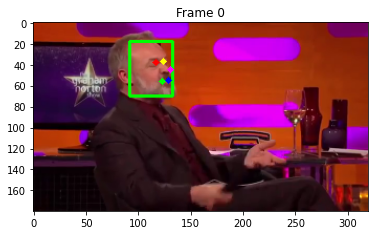

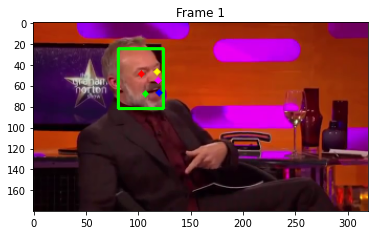

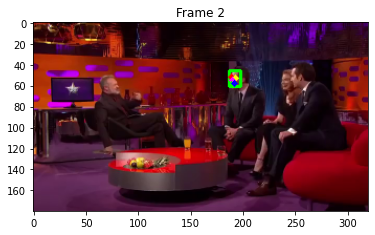

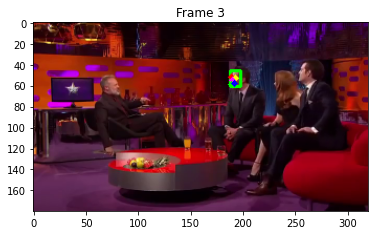

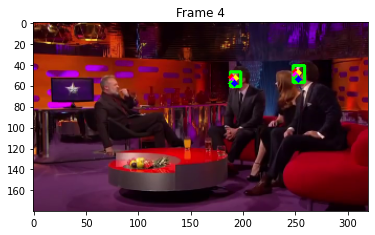

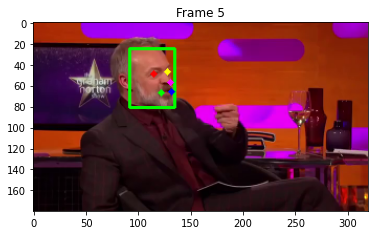

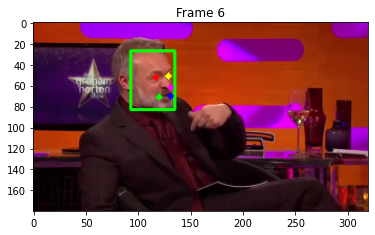

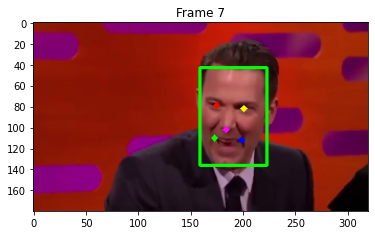

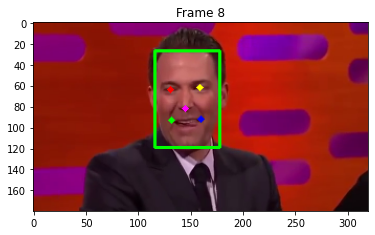

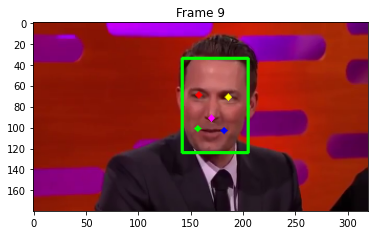

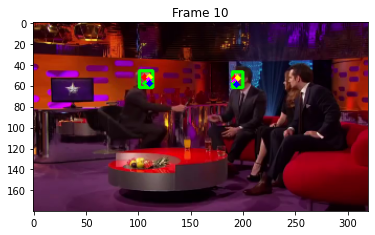

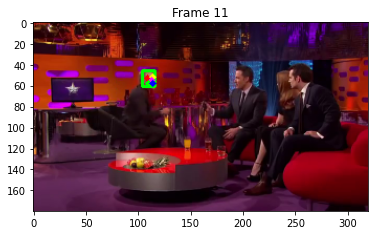

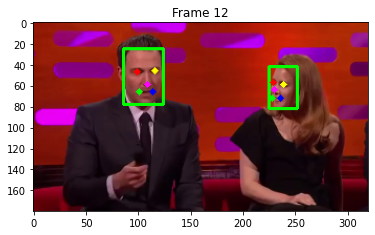

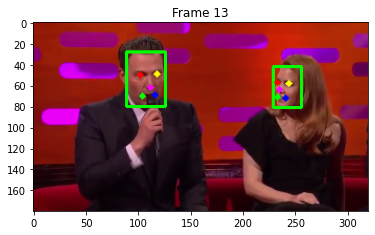

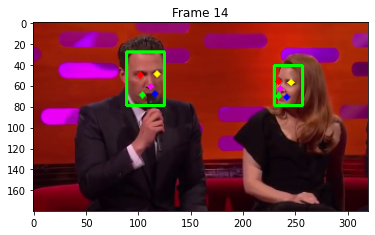

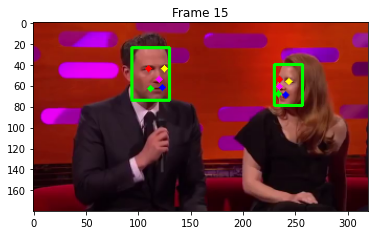

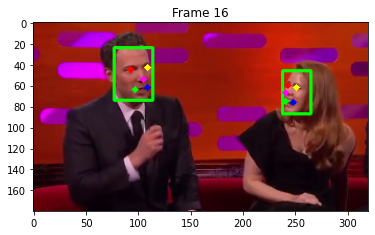

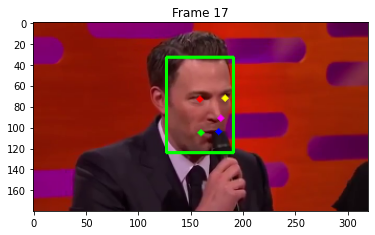

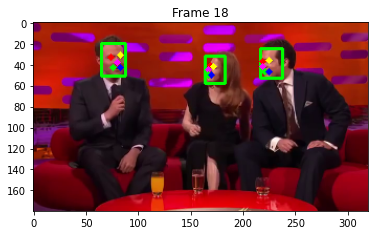

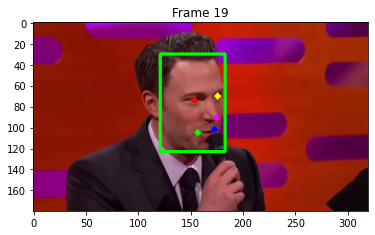

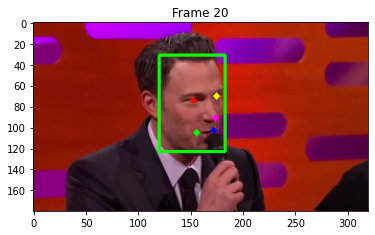

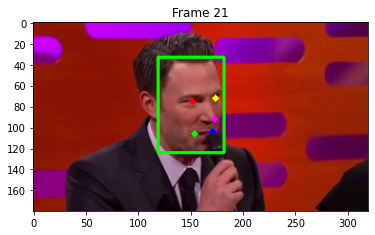

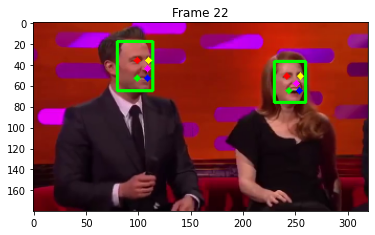

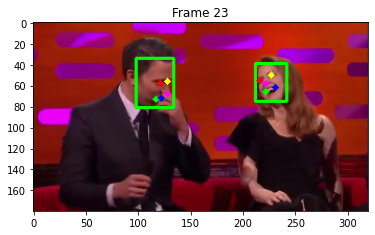

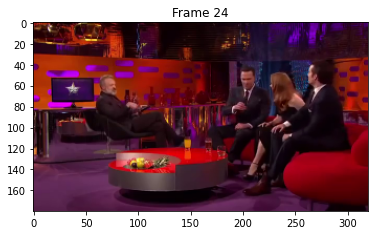

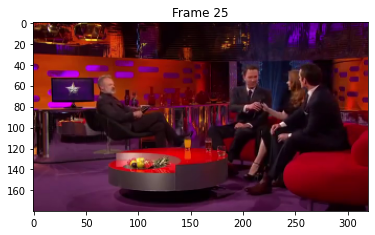

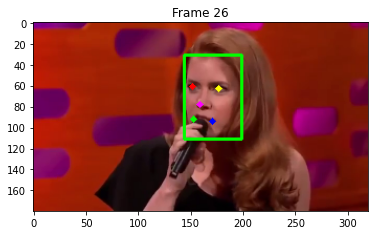

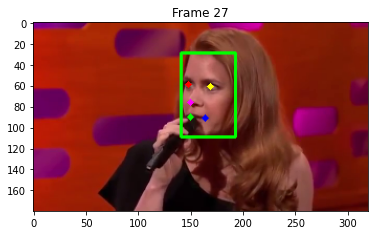

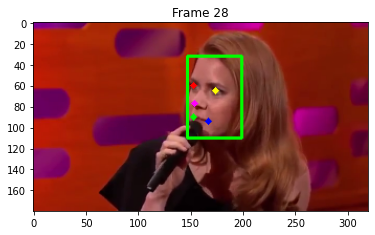

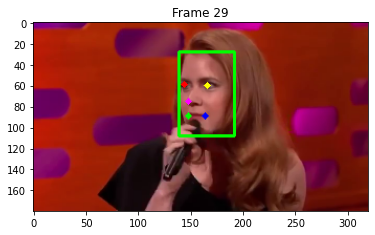

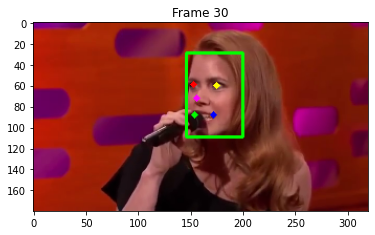

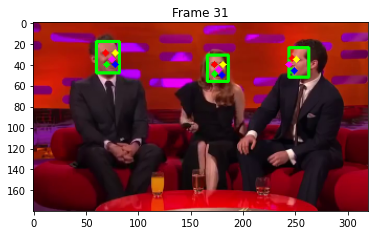

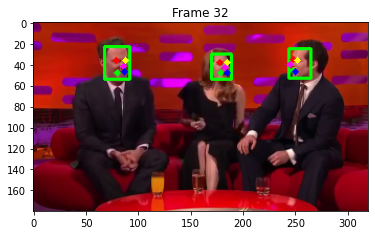

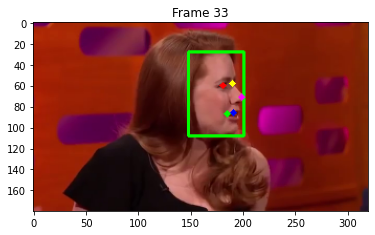

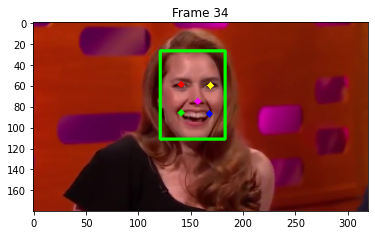

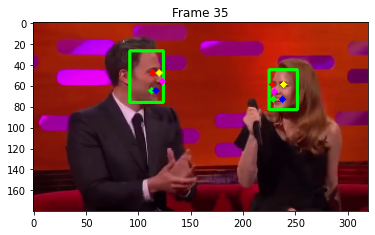

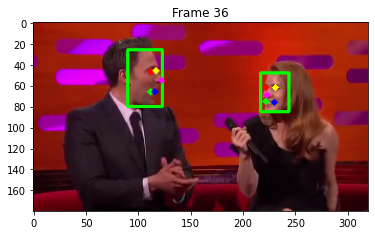

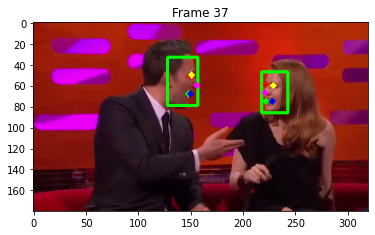

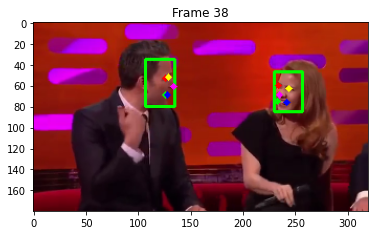

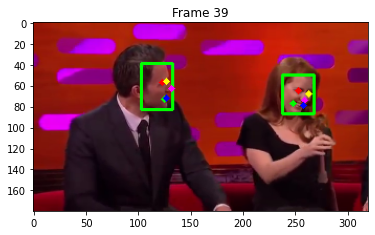

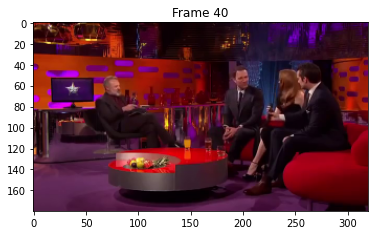

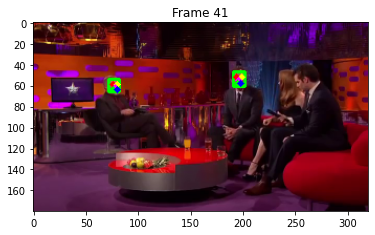

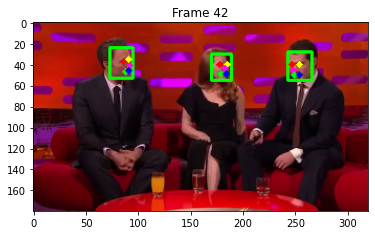

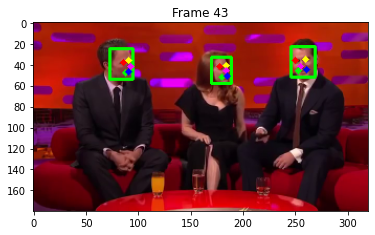

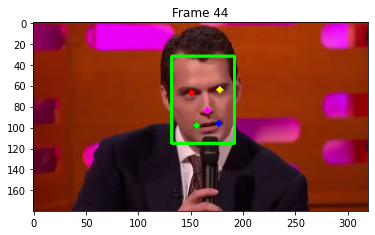

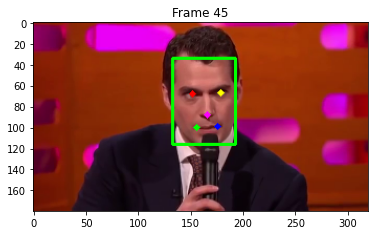

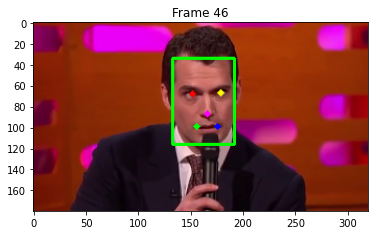

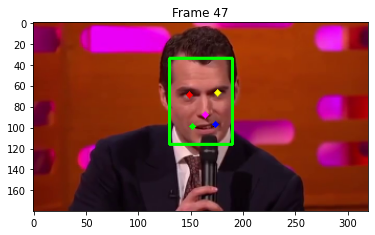

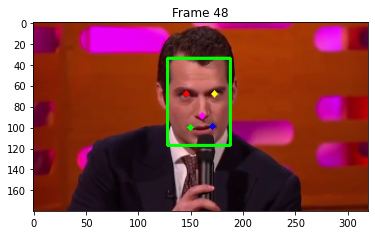

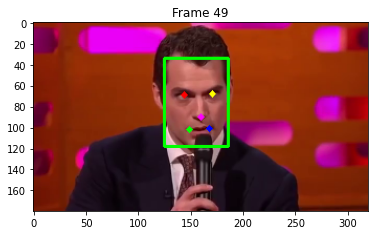

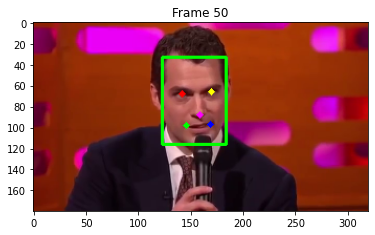

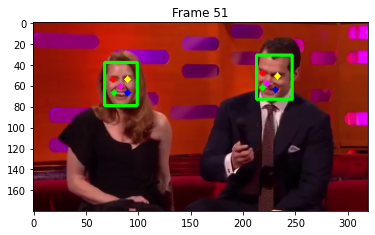

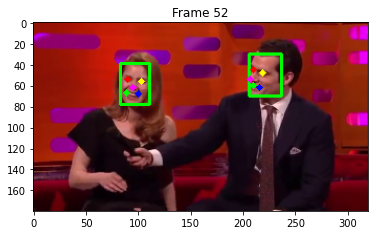

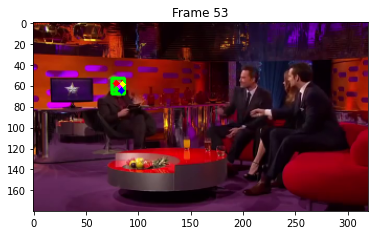

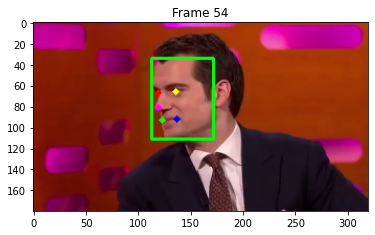

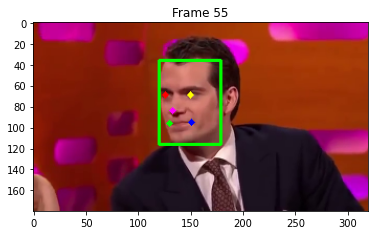

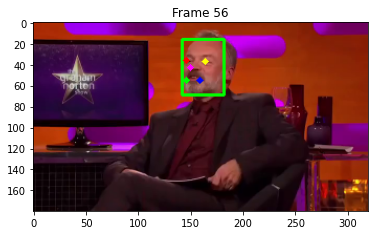

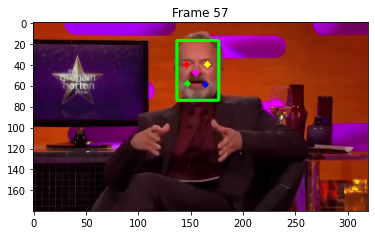

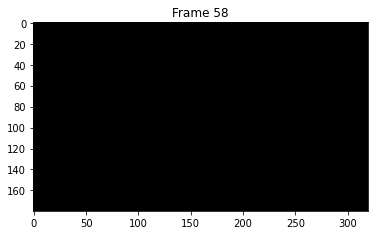

In [17]:
# Show the video with detected faces
for idx, frame in enumerate(video_fd):
    title = 'Frame %d' % idx
    plt.figure()
    plt.title(title)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

Number of frames with no face dectected : 4


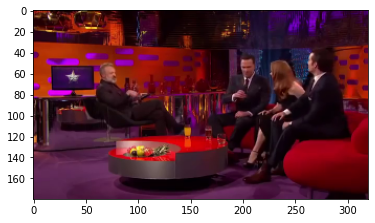

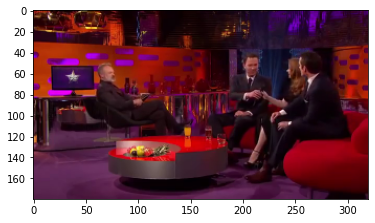

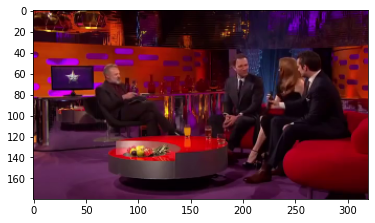

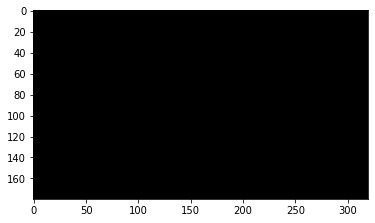

In [18]:
# show the frame with no face detected
print("Number of frames with no face dectected : " + str(len(no_face)) )
for face in no_face:
    plt.figure()
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

Number of faces dectected : 82


/var/folders/bg/_kjm8p7s0tq8sw6gkz4lbg_c0000gn/T/ipykernel_10435/3857835030.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


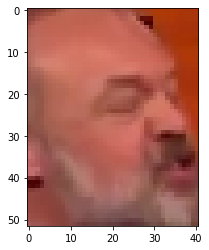

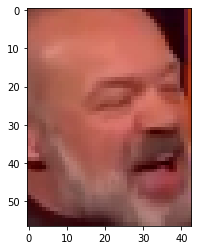

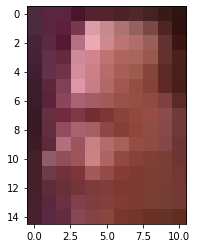

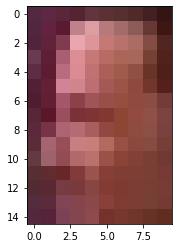

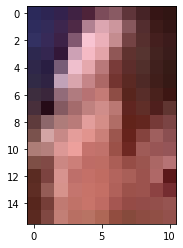

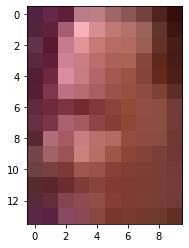

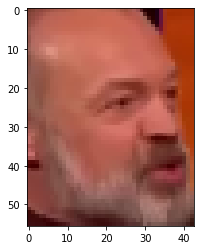

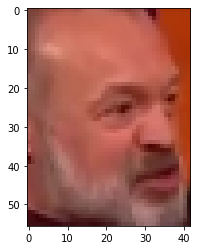

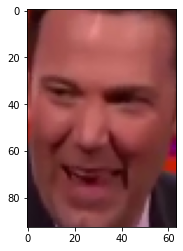

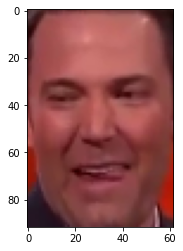

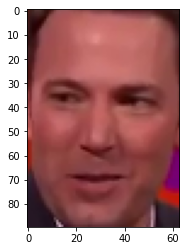

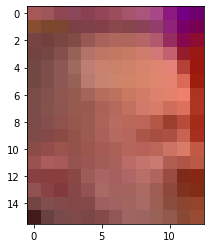

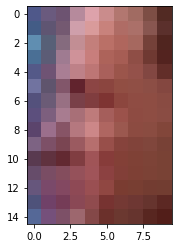

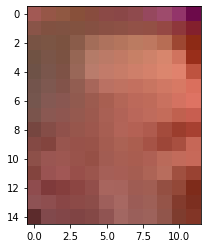

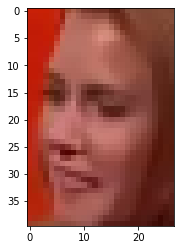

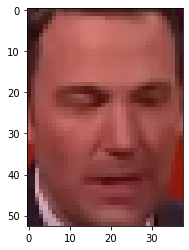

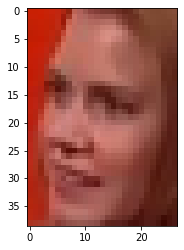

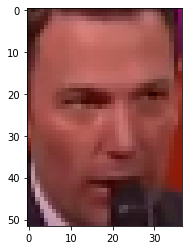

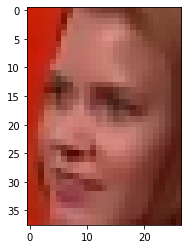

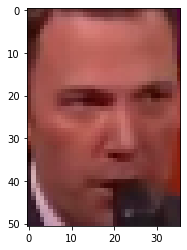

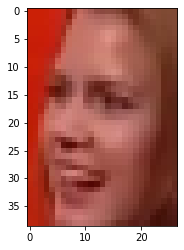

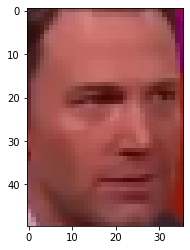

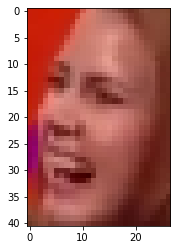

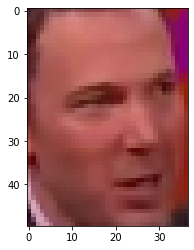

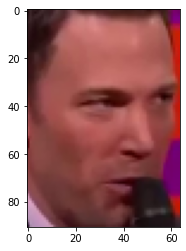

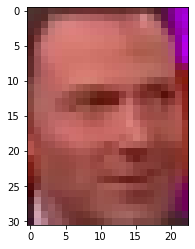

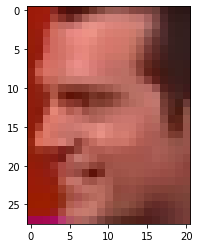

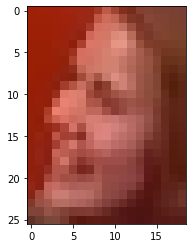

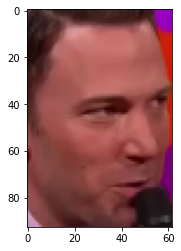

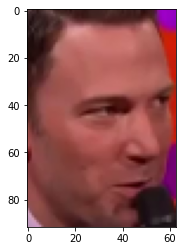

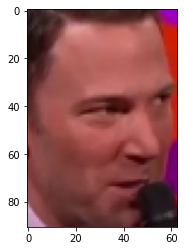

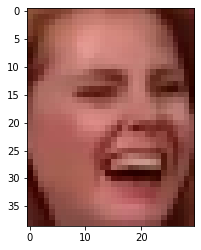

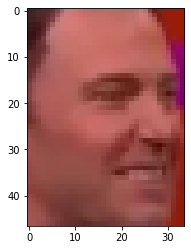

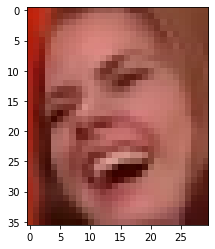

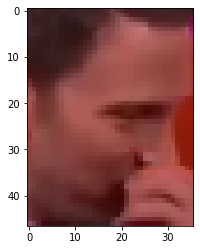

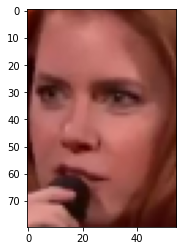

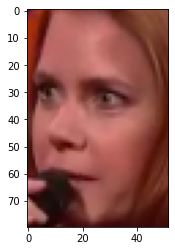

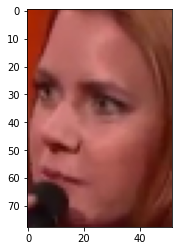

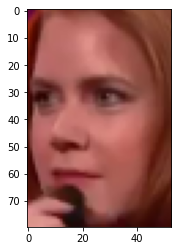

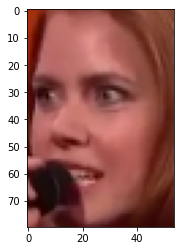

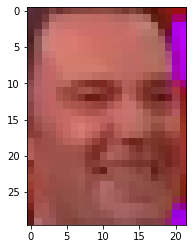

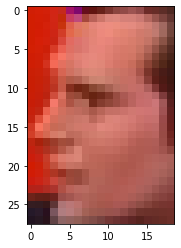

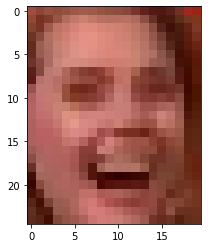

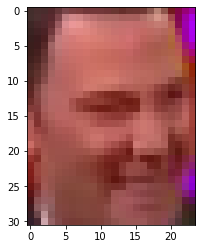

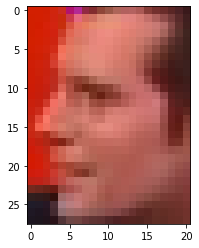

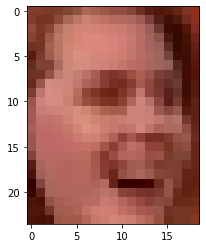

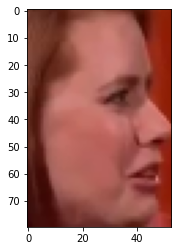

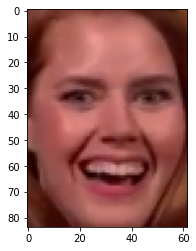

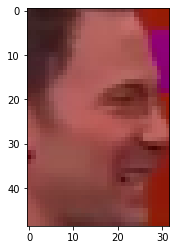

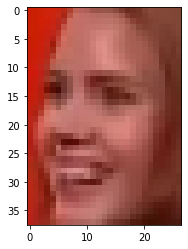

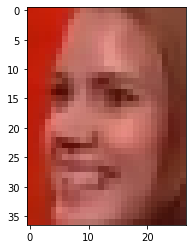

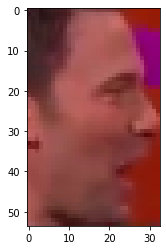

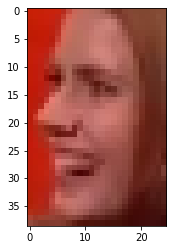

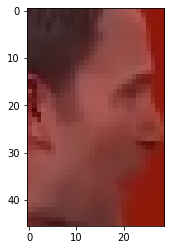

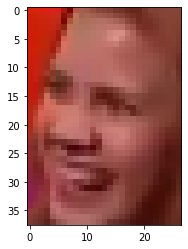

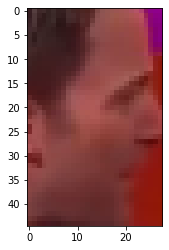

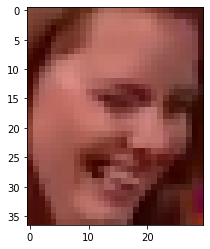

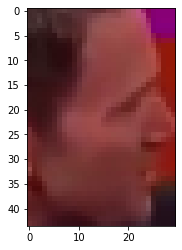

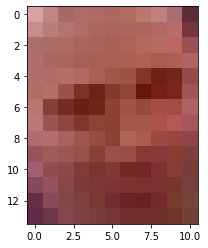

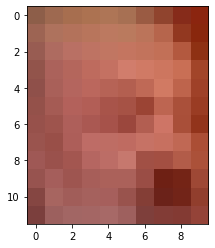

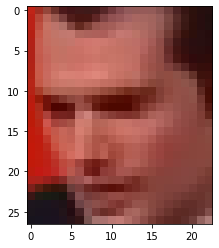

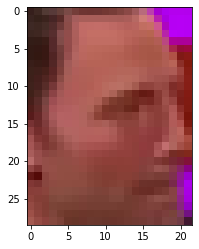

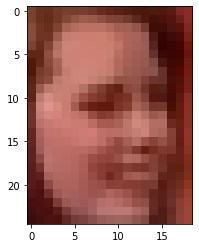

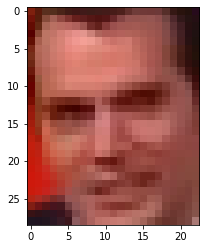

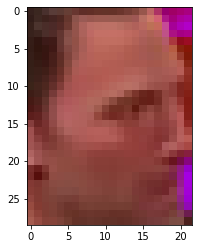

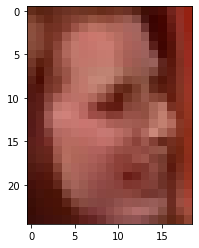

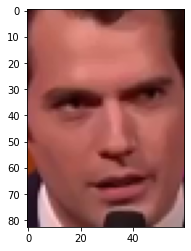

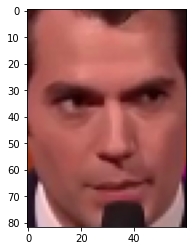

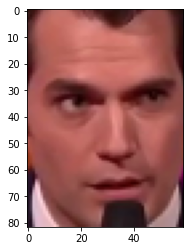

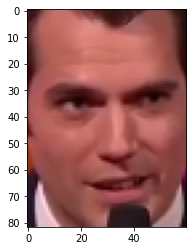

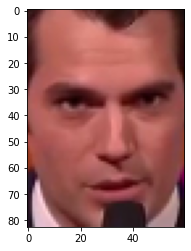

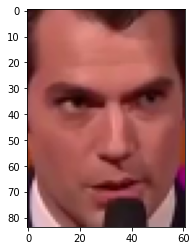

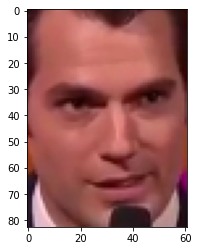

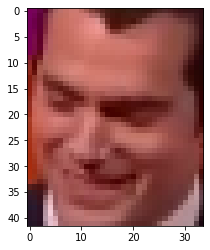

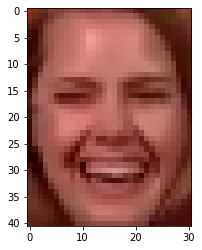

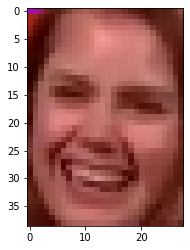

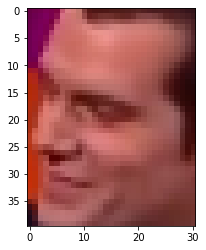

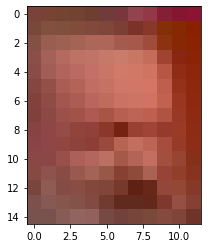

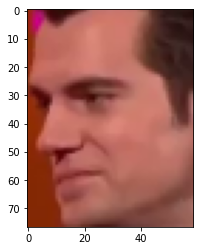

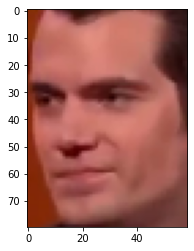

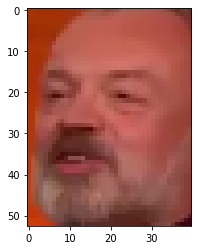

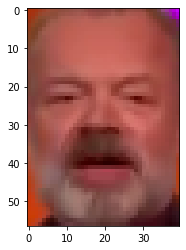

In [19]:
# show the detected faces
print("Number of faces dectected : " + str(len(crop_faces)) )
for face in crop_faces:
    plt.figure()
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

In [ ]:
# TO DO : save the results
# add metadata to the  detected faces : time stamps, confidence score, keypoints
# saves the hyperparameters margin ...